**A|B Testing en Juego Móvil  "Cookie Cats"**

In [ ]:
pip install nbconvert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!jupyter nbconvert to html AB_TESTING.ipynb

[NbConvertApp] WARNING | pattern 'to' matched no files
[NbConvertApp] WARNING | pattern 'html' matched no files
[NbConvertApp] Converting notebook AB_TESTING.ipynb to html
[NbConvertApp] Writing 365062 bytes to AB_TESTING.html


In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy.stats import shapiro,levene, ttest_ind, mannwhitneyu
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
path = "/content/cookie_cats.csv"
df_ab = pd.read_csv(path)
df_ab.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [ ]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())

check_df(df_ab)

##################### Shape #####################
(90189, 5)
##################### Types #####################
userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object
##################### Head #####################
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
##################### Tail #####################
        userid  version  sum_gamerounds  retention_1  retention_7
90186  9999710  gate_30              28         True        False
90187  9999768  gate_40              51         True        False
90188  9999861  gate_40              16        False        False
##################### NA #####################
userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7      

In [ ]:
# Number of Unique User
print(df_ab.userid.nunique() == df_ab.shape[0])
# Summary Stats: sum_gamerounds
df_ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

True


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,49854.0000


In [ ]:
# A/B Groups - Target Summary Stats
df_ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0000,52.4563,256.7164,49854
gate_40,45489,16.0000,51.2988,103.2944,2640


In [ ]:
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

# Check Outliers
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

check_outlier(df_ab, "sum_gamerounds")

True

In [ ]:
plt.figure(figsize=(6,4))
plt.boxplot(df_ab["sum_gamerounds"])
plt.show()

NameError: ignored

In [ ]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

replace_with_thresholds(df_ab, "sum_gamerounds")

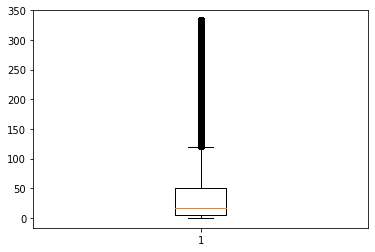

In [ ]:
plt.figure(figsize=(6,4))
plt.boxplot(df_ab["sum_gamerounds"])
plt.show()

In [ ]:
df_ab.groupby("sum_gamerounds").userid.agg("count").head()

sum_gamerounds
0.0000    3994
1.0000    5538
2.0000    4606
3.0000    3958
4.0000    3629
Name: userid, dtype: int64

**Según los datos anteriores, 3994 usuarios no han jugado Cookie Cats; y existen una gran cantidad de usuarios que han jugado el juego muy poco.** 

Ahora, lo importante es averiguar el porqué de esto. Tal vez, estos usuarios no tienen tiempo libre; o en caso de tenerlo, prefieren jugar otros juegos a los que les tengan preferencia. 

**¿Qué podemos hacer para cambiar estas cifras?**

Tactile Entertainment debería de invertir en una investigación enfocada en encontrar la respuesta del porqué los usuarios dejan el juego. Identificar los factores que toman parte en la conductas de los usuarios puede ayudarles a comprender mejor su público meta y enfocarse en brindarles lo que están buscando. Se debe entender la reacción de los jugadores en cada etapa del juego; así como su difificultad. ¿Los usuarios dejan el juego porque tiene un nivel de dificultad muy alto? ¿Los incentivos y regalías dentro de Cookie Cats, o notificaciones recordatorias del juego servirán de incentivo para que cambien estas cifras positivamente? No sabremos la respuestas a estas preguntas sin primero realizar la investigación. A|B Testing servirá de maravilla para todos los experimentos relacionados con UX. Esta primera investigación es el primer paso en la dirección correcta. 


In [ ]:
# Users reached gate 30 & gate 40 levels
df_ab.groupby("sum_gamerounds").userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

gate_30 and gate_40 son nuestros grupos de control y prueba. Se ven similares, pero debemos conocer si estos dos grupos son estadísticamente significativos. 

In [ ]:
df_ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "max"])

,count,median,mean,max
version,,,,
gate_30,44700,17.0000,46.5870,333.5000
gate_40,45489,16.0000,46.3768,333.5000


In [ ]:
df_retention = pd.DataFrame({"RET1_COUNT": df_ab["retention_1"].value_counts(),
              "RET7_COUNT": df_ab["retention_7"].value_counts(),
              "RET1_RATIO": df_ab["retention_1"].value_counts() / len(df_ab),
              "RET7_RATIO": df_ab["retention_7"].value_counts() / len(df_ab)})
df_retention

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50036,73408,0.5548,0.8139
True,40153,16781,0.4452,0.1861


Un 55% de los jugadores no jugaron Cookie Cats 1 día y un 81% de los jugadores no lo hicieron 7 días después de su instalación. 


In [ ]:
df_ab["Retention"] = np.where((df_ab.retention_1 == True) & (df_ab.retention_7 == True), 1,0)
df_ab.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "max"])

count   median     mean      max
version Retention                                  
gate_30 0          38024  12.0000  27.6288 333.5000
        1           6676 127.0000 154.5658 333.5000
gate_40 0          38983  12.0000  27.6771 333.5000
        1           6506 133.0000 158.4227 333.5000

In [ ]:
# Defining A/B groups
df_ab["version"] = np.where(df_ab.version == "gate_30", "A", "B")
df_ab.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7,Retention
0,116,A,3.0000,False,False,0
1,337,A,38.0000,True,False,0
2,377,B,165.0000,True,False,0
3,483,B,1.0000,False,False,0
4,488,B,179.0000,True,True,1
5,540,B,187.0000,True,True,1
6,1066,A,0.0000,False,False,0
7,1444,B,2.0000,False,False,0
8,1574,B,108.0000,True,True,1
9,1587,B,153.0000,True,False,0


Test Stat = 0.6361, p-value = 0.0000


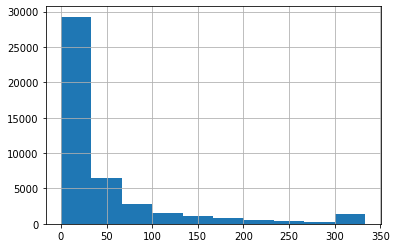

In [ ]:
test_stat, pvalue = shapiro(df_ab.loc[df_ab["version"] == "A", "sum_gamerounds"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))
df_ab.loc[df_ab["version"] == "A", "sum_gamerounds"].hist()
plt.show()

Test Stat = 0.6388, p-value = 0.0000


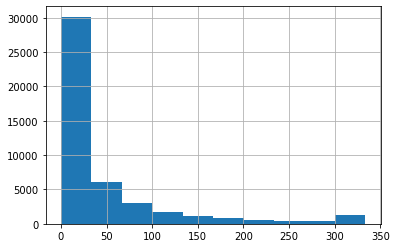

In [ ]:
test_stat, pvalue = shapiro(df_ab.loc[df_ab["version"] == "B", "sum_gamerounds"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))
df_ab.loc[df_ab["version"] == "B", "sum_gamerounds"].hist()
plt.show()

Como podemos ver p value < 0.05 y no paramétrico, y H0 Rechazado; usaremos mannwhitneyu.

In [ ]:
test_stat, pvalue = mannwhitneyu(df_ab.loc[df_ab["version"] == "A", "sum_gamerounds"].dropna(),
                                 df_ab.loc[df_ab["version"] == "B", "sum_gamerounds"].dropna())
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 1024339918.5000, p-value = 0.0499


p value < 0.05 , Mann Whitney U Testing también rechazó H0 hypothesis y aprendimos que los grupos A/B no son similares. 

Existe una diferencia significativa estadísticamente entre los dos grupos sobre el cambio de la primera puerta del nivel 30 al nivel 40 para las rondas del juego. 

In [ ]:
df_ab.groupby("version").retention_1.mean(), df_ab.groupby("version").retention_7.mean()

(version
 A   0.4482
 B   0.4423
 Name: retention_1, dtype: float64, version
 A   0.1902
 B   0.1820
 Name: retention_7, dtype: float64)

A pesar de que los resultados son muy cercanos, existe una pequeña ventaja si la primera puerta se queda en el nivel 30.
